# Agents

> The core abstraction for different FL Agents/Clients.

In [ ]:
#| default_exp federated.agents

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

'0.19.1'

In [ ]:
#| export
from fastcore.utils import *
from fastcore.all import *
import os
import networkx as nx
import pickle
import json
from collections import defaultdict,OrderedDict
from copy import deepcopy
from enum import Enum
import torch
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from peft import *
from community import community_louvain
from fedai.utils import *
from fedai.client_selector import *
from fedai.optimizers import *
from fedai.data.core import LLMDataCollator
from tqdm import tqdm
import numpy as np
from loguru import logger
from fedai.utils import *
from fedai.metrics import *
from fedai.losses import *
from transformers import AutoTokenizer
from omegaconf.dictconfig import DictConfig
import numpy as np
import math
np.random.seed(42)
torch.manual_seed(42)

<torch._C.Generator>

In [ ]:
#| export
class AgentRole(Enum):
    SERVER = 1
    CLIENT = 2
    MARL = 3

## Base Agent

An agent is an entity that has a state and exist in an environment. In the case of Federated learning (FL), the agent's state is defined as its own model, data, criterion, optimizer. FL Focuses on distributed model training across multiple clients (agents), each with its local data. Clients **collaborate** to improve a global or shared model while keeping their data private. Communication is often periodic (e.g., every few training rounds). On the other hand, Multi-agent RL systems (MARL) Involves multiple agents interacting with an environment to learn policies for specific tasks (e.g., navigation, resource allocation). Each agent has a state also, but the state represntation might differ slightly from that of an FL agent. The data is often not preloaded as in FL rather, it's collected from the environemnt.

In [ ]:
#| export
class Agent:
    def __init__(self,
                 id,
                 cfg,
                 state= None,
                 role= AgentRole.CLIENT):
        
        self.id = id # each agent has a unique id
        self.cfg = cfg # contains all the configurations needed for the agent/trainer.
        self.state = state # A dictionary containing the state of the agent
        self.role = role # either a client or a server

In [ ]:
#| export
@patch
def init_agent(self: Agent):
    # Initialize the state of the agent. In FL Agent, this means making any adjustments to the model/optimizer/state_dict/...etc
    raise NotImplementedError

In [ ]:
#| export
@patch
def communicate(self: Agent, msg):
    raise NotImplementedError

In [ ]:
#| export
@patch
def update_state(self: Agent):
    raise NotImplementedError

In [ ]:
#| export
@patch
def save_state(self: Agent):
    # save the state of the agent to a file on disk (id, model, optimizer, loss_fn).
    raise NotImplementedError

In [ ]:
#| export
@patch
def clear_model(self: Agent):
    self.model = None

## MARL Agent

In [ ]:
class MARLAgent(Agent):
    def _sense(self, state):
        # sense the environment
        self.state = state

    def _decide(self):
    # Compute the next action(s) based on the current state and observations.
        pass

    def _act(self):
        pass
    

## FL Agent (FedAVG)

In [ ]:
#| export
class FLAgent(Agent):
    # A Federated Learning Agent implementing `FedAVG`.
    def __init__(self,
                 id, # the id of the agent
                 cfg, # the configuration of the agent.
                 state= None, # the state of the agent (model, optimizer, loss_fn), etc.
                 role= AgentRole.CLIENT, # the role of the agent (client or server)
                 block= None # The data block (local data of the FL Agent).
                 ):  
                 
        super().__init__(id, cfg, state, role)

        if self.role == AgentRole.CLIENT:
            self.train_ds, self.test_ds = block[0], block[1]
            
            for key, value in self.state.items():
                setattr(self, key, value)

            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
            self.train_loader = prepare_dl(self.cfg, self.train_ds)  # noqa: F405
            self.test_loader = prepare_dl(self.cfg, self.test_ds) # noqa: F405

            self.training_metrics = Metrics(list(self.cfg.training_metrics))  # noqa: F405
            self.test_metrics = Metrics(list(self.cfg.test_metrics))  # noqa: F405

            self.data_key, self.label_key = 'x', 'y'

In [ ]:
#| export 
@patch
def server_init(self: FLAgent, client_fn, client_selector, client_cls, loss_fn, writer):
    self.client_fn = client_fn
    self.client_selector = client_selector
    self.client_cls = client_cls
    self.loss_fn = loss_fn
    self.writer = writer
    self.latest_round = {}

Since data blocks are already on the disk, and since RL agents don't have a preloaded data blocks, we don't include the data in the FL agent's state. Another ratioanle behind this decision is that, state should contain dynamic objects that change over the interaction of the agents and data blocks are static in the case of FL agents, unless you are doing FL-RL Agents. 

For every client abstraction, whether it a base or any other type of federated client, it will initalize the training locally with a set of steps. This might include things like extracting the peft model out of the base model (in the case of LLMs clients). Also, it will terminate the local training with some steps, like saving the model state dictionary and so on.

In [ ]:
#| export
@patch
def runFL(self: FLAgent):
    res =  []
    all_ids = self.client_selector.select()
    
    for t in range(1, self.cfg.n_rounds + 1):
        lst_active_ids = all_ids[t]
        len_clients_ds = []
        
        train_res, test_res = self.evaluate(t)
        train_df, test_df = self.writer.write(lst_active_ids, train_res, test_res, t) 
        res.append((train_df, test_df))
        
        for id in lst_active_ids:
            client = self.client_fn(self.client_cls, self.cfg, id, self.latest_round, t, self.loss_fn, to_read_from= 'global_model')
            len_clients_ds.append(len(client.train_ds))
            
            self.communicate(client) 
            client.fit()

            client.communicate(self) 
            self.latest_round[id] = t 

        self.aggregate(lst_active_ids, t, len_clients_ds)
        
        
        
        
    self.writer.save(res)
    self.writer.finish()

    return res

In [ ]:
#| export
@patch
def evaluate(self: FLAgent, t):
    lst_train_res = []
    lst_test_res = []
    for id in range(self.cfg.num_clients):
        client = self.client_fn(self.client_cls, self.cfg, id, self.latest_round, t, self.loss_fn, to_read_from= 'global_model')
        
        res_train = client.evaluate_local(loader= 'train')
        lst_train_res.append(res_train)

        res_test = client.evaluate_local(loader= 'test')
        lst_test_res.append(res_test)
    return lst_train_res, lst_test_res    


We will adjust the string reprsntation of the client abstraction to make it more meaningful.

In [ ]:
#| export
@patch
def __str__(self: FLAgent) -> str:
    return f'''{self.__class__.__name__}: {self.__class__.__name__}
    Index : {self.id}
    Model: {self.model.__class__.__name__}
    Criterion: {self.criterion.__class__.__name__}
    Optimizer: {self.optimizer.__class__.__name__}'''


In [ ]:
#| export
@patch
def clear_model(self: FLAgent):
    self.model = None if hasattr(self, 'model') else None

In [ ]:
#| export
@patch
def get_batch(self: FLAgent, batch):
    return {k: v.to(self.device) for k, v in batch.items()}

In [ ]:
#| export
@patch
def _forward(self: FLAgent, batch):
    X, y = batch['x'], batch['y']
    outputs = self.model(X)
    loss = self.criterion(outputs, y)
    return loss, outputs

In [ ]:
#| export
@patch
def _closure(self: FLAgent, batch: dict) -> tuple:
    metrics = {k: 0 for k in list(self.cfg.training_metrics)}  # Ensure metrics is always defined

    try:
        loss, logits = self._forward(batch)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        y_pred = probs.argmax(dim=-1)
        y_true = batch[self.label_key]

        if hasattr(self, "training_metrics") and self.cfg.training_metrics:
            if hasattr(self, "tokenizer"):
                metrics = self.training_metrics.compute(y_pred=y_pred, y_true=y_true, tokenizer=self.tokenizer)
            else:
                metrics = self.training_metrics.compute(y_pred=y_pred, y_true=y_true)

    except Exception as e:
        return torch.tensor(0.0, dtype=torch.float32, device=self.device), metrics  # Return safe values

    return loss, metrics


In [ ]:
#| export
@patch
def _run_batch(self: FLAgent, batch: dict) -> tuple:
    self.optimizer.zero_grad()
    loss, metrics = self._closure(batch)

    if loss.item() == 0.0:
        return loss, metrics
    
    loss.backward()
    
    if self.cfg.model.grad_norm_clip:
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.model.grad_norm_clip)

    self.optimizer.step()

    return loss, metrics

In [ ]:
#| export
@patch
def _run_epoch(self: FLAgent):

    for i, batch in enumerate(self.train_loader):
        batch = self.get_batch(batch)
        self._run_batch(batch)

In [ ]:
#| export
@patch
def fit(self: FLAgent) -> dict:
    
    self.model = self.model.to(self.device)
    self.model.train()
    for _ in range(self.cfg.local_epochs):
        self._run_epoch()


In [ ]:
#| export
@patch
def evaluate_local(self: FLAgent, loader= 'train') -> dict:
    total_loss = 0
    lst_metrics = []

    self.model = self.model.to(self.device)
    self.model.eval()
    num_eval = 0
    data_loader = self.train_loader if loader == 'train' else self.test_loader
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            batch = self.get_batch(batch)
            loss, metrics = self._closure(batch)                 

            if not math.isnan(loss.item()):
                total_loss += loss.item()  
                num_eval += len(batch[self.data_key])  # Ensure num_eval is updated
                lst_metrics.append(metrics)           
    
    avg_loss = total_loss / num_eval if num_eval > 0 else 0.0

    if lst_metrics:
        total_metrics = {k: sum(m.get(k, 0) for m in lst_metrics) / len(lst_metrics) for k in self.cfg.test_metrics}
    else:
        total_metrics = {k: 0.0 for k in self.cfg.test_metrics}

    return {"loss": avg_loss, "metrics": total_metrics}


In [ ]:
#| export
@patch
def save_state(self: FLAgent, state_dict):  # noqa: F811
    # save the model to self.cfg.save_dir/comm_round/f"local_output_{id}"/state.pth
    
    state_path = os.path.join(self.cfg.save_dir, 
                              str(self.t),
                              f"local_output_{self.id}",
                              "state.pth")
    if not os.path.exists(os.path.dirname(state_path)):
        os.makedirs(os.path.dirname(state_path))

    state_dict['model'] = self.model.state_dict()
    state_dict['optimizer'] = self.optimizer.state_dict()

    torch.save(state_dict, state_path)

    if self.role == AgentRole.CLIENT:
        save_space(self)


> To do: implement the communication process in **Protobuf**.

### Communication

Communication refers to the process of downloading and uploading models from the server and to the client. Since we are safeguarding against memory issues, we use sequential client processing and disk checkpointing as our tools.

In [ ]:
#| export
@patch
def communicate(self: Agent, another_agent: Agent):  # noqa: F811
    if self.role == AgentRole.CLIENT:
        self.save_state(self.state)

### Aggregation


The aggegation for `fedavg` is defined as:

$$m_t \leftarrow \sum_{k \in S_t} n_k$$
$$W_{global}^{(t + 1)} \leftarrow \sum_{k \in S_t} \frac{n_k}{m_t} w_k^{(t + 1)}$$

where $S_t$ is the set of active clients at communication round $t$.

In [ ]:
#| export
@patch
def aggregate(self: FLAgent, lst_active_ids, comm_round, len_clients_ds):
        
    m_t = sum(len_clients_ds)
    with torch.no_grad():
        for i, id in enumerate(lst_active_ids):
            state_path = os.path.join(self.cfg.save_dir, 
                                    str(comm_round),
                                    f"local_output_{id}",
                                    "state.pth")
            
            state = torch.load(state_path, weights_only=False)
            client_state_dict = state['model']

            if i == 0:
                global_model = {
                    key: torch.zeros_like(value) 
                    for key, value in client_state_dict.items()
                }

            n_k = len_clients_ds[i]
            weight =  n_k / m_t 

        
            for key in client_state_dict.keys():
                global_model[key].add_(weight * client_state_dict[key])


        server_state = {
            'model': global_model,
        }

        server_state_path = os.path.join(self.cfg.save_dir, 
                                    str(comm_round),
                                    "global_model",
                                    "state.pth")
        
        if not os.path.exists(os.path.dirname(server_state_path)):
            os.makedirs(os.path.dirname(server_state_path), exist_ok=True)
        torch.save(server_state, server_state_path)

    

## Fedu Agent (MTL)

This client uses **Multi-Task-Learning** scheme to personalize the models in a non-iid setting.

In [ ]:
#| export
class Fedu(FLAgent):
    def __init__(self, 
                 id,
                 cfg,
                 state= None,
                 role= AgentRole.CLIENT,
                 block= None):
        
        super().__init__(id, cfg, state, role, block)

        b = np.random.uniform(0,1,size=(self.cfg.num_clients, self.cfg.num_clients))
        b_symm = (b + b.T)/2
        b_symm[b_symm < 0.25] = 0
        self.alk_connection = b_symm

This Algorithm learns a model per client, and add a new aggregation scheme defined as

$$ W_{k}^{(t)} = W_{k, R}^{(t)} - \lambda \eta_2 \sum_{\ell \in N_k} a_{k, \ell} (W_{k, R}^{(t)} - W_{\ell, R}^{(t)})$$

where $\lambda$ is a regularization parameter and $\eta_2$ is defined as $$\eta_2 = \eta_1 * R $$

such that $\eta_1$ is the local learning rate, and $R$ is the number of lcoal iterations.

In [ ]:
#| export
@patch
def aggregate(self: Fedu, lst_active_ids, comm_round, len_clients_ds):

    global_lr = float(self.cfg.lr) * float(self.cfg.local_epochs)
    reg_param = self.cfg.lambda_
    
    with torch.no_grad():
        for i, id in enumerate(lst_active_ids):
            state_path = os.path.join(self.cfg.save_dir, 
                                    str(comm_round),
                                    f"local_output_{id}",
                                    "state.pth")
            
            state = torch.load(state_path, weights_only= False)
            client_state_dict = state['model']

            client_diff = {
                key: torch.zeros_like(value) 
                for key, value in client_state_dict.items()
            }
            
            for j, other_id in enumerate(lst_active_ids):
                if i == j:
                    continue
                other_state_path = os.path.join(self.cfg.save_dir,
                                                str(comm_round),
                                                f"local_output_{other_id}",
                                                "state.pth")
                
                other_state = torch.load(other_state_path, weights_only= False)
                other_state_dict = other_state['model']

                weight = self.alk_connection[int(id)][int(other_id)]
                for key in client_state_dict.keys():
                    client_diff[key].add_(weight * (client_state_dict[key] - other_state_dict[key]))

            for key in client_state_dict:
                client_state_dict[key].sub_(global_lr * reg_param * client_diff[key])

            clinet_state = {
                'model': client_state_dict,
            }

            agg_client_state_path = os.path.join(self.cfg.save_dir,
                                                 str(comm_round),
                                                 f"aggregated_model_{id}",
                                                 "state.pth")
            
            if not os.path.exists(os.path.dirname(agg_client_state_path)):
                os.makedirs(os.path.dirname(agg_client_state_path))

            torch.save(clinet_state, agg_client_state_path)

## DMTL-G (MTL)
Distributed Multi-Task Learning over Graphs: A game-theoretic approach

In [ ]:
#| export
class DMTL(FLAgent):
    def __init__(self, 
                 id,
                 cfg,
                 state= None,
                 role= AgentRole.CLIENT,
                 block= None):
        
        super().__init__(id, cfg, state, role, block)
        
        if self.role == AgentRole.CLIENT:
            self.anchorloss = AnchorLoss(self.cfg.data.num_classes, self.cfg.model.hidden_size).to(self.device)
            self.anchorloss.anchor = self.h_c if self.t > 1 else self.anchorloss.anchor
            self.label_set = list(set(np.array([batch['y'] for batch in self.train_ds])))

In [ ]:
#|hide
from omegaconf import OmegaConf 
cfg = OmegaConf.load('./examples/cfg.yaml')
cfg.data.classes

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#| export 
@patch
def server_init(self: DMTL, client_fn, client_selector, client_cls, loss_fn, writer):
    FLAgent.server_init(self, client_fn, client_selector, client_cls, loss_fn, writer)
    self.classes = self.cfg.data.classes
    self.idx_to_cls = {i: self.classes[i] for i in range(len(self.classes))}

In [ ]:
#| export
@patch
def runFL(self: DMTL):
    res =  []
    all_ids = self.client_selector.select()
    
    for t in range(1, self.cfg.n_rounds + 1):
        lst_active_ids = all_ids[t]
        len_clients_ds = {}
        
        for id in lst_active_ids:
            client = self.client_fn(self.client_cls, self.cfg, id, self.latest_round, t, self.loss_fn, to_read_from= 'aggregated_model_')
            len_clients_ds[id] = len(client.train_ds)
            
            self.communicate(client) 
            client.fit()

            client.communicate(self) 
            self.latest_round[id] = t 

        self.aggregate(lst_active_ids, t, len_clients_ds)
        # self.extra_computation(lst_active_ids, t)
        
        train_res, test_res = self.evaluate(t)
        train_df, test_df = self.writer.write(lst_active_ids, train_res, test_res, t) 
        res.append((train_df, test_df))
        
    self.writer.save(res)
    self.writer.finish()

    return res

In [ ]:
#| export
@patch
def _forward(self: DMTL, batch):
    from IPython.core.debugger import Pdb
    ipdb = Pdb(); ipdb.set_trace()
    X, y = batch['x'], batch['y']
    y_copied = deepcopy(y)
    labels = y.type(torch.LongTensor).to(self.device)
    ys = labels.float()
    
    h = self.model.encoder(X)
    outputs = self.model.classifier(h)    
    
    loss_anchor = self.anchorloss(h, ys, Lambda = self.cfg.lambda_anchor)
    loss = self.criterion(outputs, y_copied)
    return loss + loss_anchor, h, outputs, labels

In [ ]:
#| export
@patch
def _closure(self: DMTL, batch: dict) -> tuple:
    metrics = {k: 0 for k in list(self.cfg.training_metrics)}  # Ensure metrics is always defined
    h, labels = None, None
    try:
        loss, h, logits, labels = self._forward(batch)

        probs = torch.nn.functional.softmax(logits, dim=-1)
        y_pred = probs.argmax(dim=-1)
        y_true = batch[self.label_key]

        if hasattr(self, "training_metrics") and self.cfg.training_metrics:
            if hasattr(self, "tokenizer"):
                metrics = self.training_metrics.compute(y_pred=y_pred, y_true=y_true, tokenizer=self.tokenizer)
            else:
                metrics = self.training_metrics.compute(y_pred=y_pred, y_true=y_true)

    except Exception as e:
        print(e)
        return torch.tensor(0.0, dtype=torch.float32, device=self.device), metrics, h, labels  # Return safe values

    return loss, metrics, h, labels


In [ ]:
#| export
@patch
def _run_batch(self: DMTL, batch: dict) -> tuple:
    batch_mean_anchor = torch.zeros(self.cfg.data.num_classes, self.cfg.model.hidden_size).to(self.device)
    self.optimizer.zero_grad()

    loss, metrics, h, labels = self._closure(batch)
    if loss.item() == 0.0 or h is None:
        return loss, metrics, batch_mean_anchor
    
    for i in set(labels.tolist()):
        batch_mean_anchor[i] += torch.mean(h[labels==i],dim=0)
   
    loss.backward()
    
    if self.cfg.model.grad_norm_clip:
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.model.grad_norm_clip)

    self.optimizer.step()

    return loss, metrics, batch_mean_anchor

In [ ]:
#| export
@patch
def _run_epoch(self: DMTL):

    epoch_mean_anchor = torch.zeros(self.cfg.data.num_classes, self.cfg.model.hidden_size).to(self.device)
    for batch_idx, batch in enumerate(self.train_loader):
        batch = self.get_batch(batch)
        _, _, batch_mean_anchor = self._run_batch(batch)

        for i in self.label_set:
            #compute batch mean anchor according to batch label
            batch_mean_anchor[i] = batch_mean_anchor[i]/(batch_idx+1)

            #compute epoch mean anchor according to batch mean anchor
            lambda_momentum = self.cfg.momentum_anchor #pow(2, -(epoch+1))
            epoch_mean_anchor[i] = lambda_momentum*epoch_mean_anchor[i] + (1-lambda_momentum)*batch_mean_anchor[i]
        

    self.anchorloss.anchor =  torch.nn.Parameter(epoch_mean_anchor, requires_grad=False)

In [ ]:
#| export
@patch
def evaluate(self: DMTL, t):
    lst_train_res = []
    lst_test_res = []
    for id in range(self.cfg.num_clients):
        client = self.client_fn(self.client_cls, self.cfg, id, self.latest_round, t, self.loss_fn, to_read_from= 'aggregated_model_')
        
        res_train = client.evaluate_local(loader= 'train')
        lst_train_res.append(res_train)

        res_test = client.evaluate_local(loader= 'test')
        lst_test_res.append(res_test)
    return lst_train_res, lst_test_res    


In [ ]:
#| export 
@patch
def pick_n_points(self: DMTL, n= 3):
    pass

### Communication

The communication in DMTL is a matter of sending (saving to the disk) two things, the classification head and a randomly picked data represntation.

In [ ]:
#| export
@patch
def save_state(self: DMTL, state_dict):  # noqa: F811
    # save the model to self.cfg.save_dir/comm_round/f"local_output_{id}"/state.pth
    
    
    state_dict['model'] = self.model.state_dict()
    state_dict['optimizer'] = self.optimizer.state_dict()
    state_dict['h'] = self.anchorloss.anchor # (num_classes, hidden_size)
    state_dict['label_set'] = self.label_set
    
    # pick a random data point from the train_ds and save it to the state_dict
    # data_point = self.train_ds[np.random.randint(0, len(self.train_ds))]
    # data_point = self.get_batch(data_point)
    # data = data_point['x']
    # batched_data_point = data.view(1, 3, 32, 32) # (B, C, H, W)
    # state_dict['h'] = self.model.encoder(batched_data_point)

    state_path = os.path.join(self.cfg.save_dir, str(self.t), f"local_output_{self.id}", "state.pth")
    if not os.path.exists(os.path.dirname(state_path)):
        os.makedirs(os.path.dirname(state_path))

    torch.save(state_dict, state_path)

    if self.role == AgentRole.CLIENT:
        save_space(self)


### Server side

At the server, we are doing the followin steps:
- Form the coalitions.
  - First, construct the weighted undirected graph $\mathcal{g}$.
  - Second, pass this graph to the louvian algorithm to get the communities.
- aggregate based on the equations stated in the next cells.


First, model similrity is compared using the norm of the difference between the two models as follows:
$$\operatorname{Sim}_{\text {head }}(\bm{w}_k,\bm{w}_\ell)=\left\|\bm{w}_k-\bm{w}_\ell\right\|,$$


In [ ]:
#| export
@patch
def model_similarity(self: DMTL, model1, model2):
    total_l1_norm = 0.0
    
    for key in model1.keys():
        param1 = model1[key]
        param2 = model2[key]
        
        total_l1_norm += torch.norm(param1 - param2, p=1).item()
    
    return total_l1_norm

We compare the embedding closeness using cosine similiairy.


$$\operatorname{Sim}_{\mathrm{repr}}(k, \ell) = \cos(\Omega) = \frac{\mathbf{h}_k \cdot \mathbf{h}_{\ell}}{\|\mathbf{h}_k\| \|\mathbf{h}_{\ell}\|}$$

In [ ]:
#| hide
h1 = torch.nn.Parameter(F.normalize(torch.randn(3, 512)), requires_grad=True)
h2 = torch.nn.Parameter(F.normalize(torch.randn(3, 512)), requires_grad=True)

h = print(h1.data)

h1_norm = F.normalize(h1, p=2, dim=1)  # (3, 512)
h2_norm = F.normalize(h2, p=2, dim=1)  # (3, 512)
cos_sim_matrix = torch.mm(h1_norm, h2_norm.T)  # (3, 3)
cos_sim_matrix

tensor([[ 5.1199e-02, -4.1328e-02,  2.0406e-03,  ...,  4.2562e-02,
          1.6889e-02, -7.1817e-02],
        [-7.9444e-03,  4.9498e-02, -9.6207e-02,  ..., -3.8808e-02,
         -1.8961e-05,  1.1457e-02],
        [-3.8553e-02,  3.4144e-02,  1.2492e-02,  ..., -2.2866e-02,
          3.2718e-02, -1.1679e-02]])


tensor([[ 0.0327,  0.0048, -0.0271],
        [-0.0087, -0.0430, -0.0395],
        [ 0.1083, -0.0309,  0.0110]], grad_fn=<MmBackward0>)

In [ ]:
#| hide
import torch.nn.functional as F
# ensure the batch dimension is removed
h1 = torch.randn(3, 512)
h2 = torch.randn(3, 512)

h1_norm = F.normalize(h1, p=2, dim=1)  # (3, 512)
h2_norm = F.normalize(h2, p=2, dim=1)  # (3, 512)

cos_sim_matrix = torch.mm(h1_norm, h2_norm.T)  # (3, 3)
cos_sim_matrix

tensor([[-0.0689, -0.0668,  0.0598],
        [ 0.0468,  0.0179,  0.0262],
        [ 0.0489, -0.0006,  0.0229]])

In [ ]:
#| hide
data = cos_sim_matrix.numpy()
cols = [1, 2, 3]#list({0, 1, 2})

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
idx_to_cls = {i: classes[i] for i in range(10)}
cols = [idx_to_cls[i] for i in cols]
cols2 = ['plane', 'car', 'bird']
import pandas as pd
df = pd.DataFrame(data, columns= cols, index= cols2)
df

,car,bird,cat
plane,-0.068850,-0.066812,0.059776
car,0.046795,0.017909,0.026214
bird,0.048909,-0.000647,0.022858


In [ ]:
#|hide
single_similarity = cos_sim_matrix.mean()
print(single_similarity)


tensor(0.0096)


In [ ]:
#| hide
max_similarity = cos_sim_matrix.max(dim=1).values.mean() 
print(max_similarity)


tensor(0.0518)


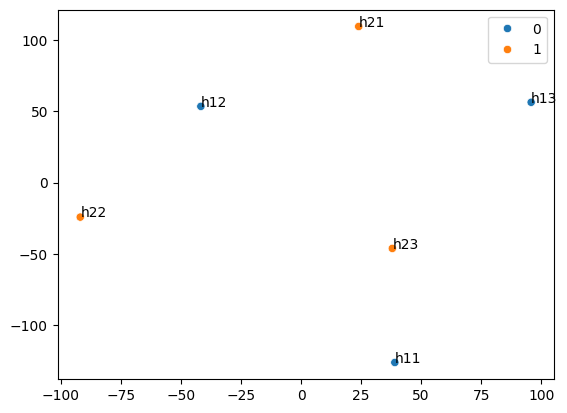

In [ ]:
#| hide
# visulaize the vcotrs in 2-d using Tsne and make each vector in the same tensor to have the same color
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0, perplexity= 4)
h = torch.cat([h1_norm, h2_norm], dim=0)
h_embedded = tsne.fit_transform(h)

sns.scatterplot(x=h_embedded[:, 0], y=h_embedded[:, 1], hue=[0, 0, 0, 1, 1, 1])
# label the vectors with h11, h12, h13, h21, h22, h23
for i, txt in enumerate(['h11', 'h12', 'h13', 'h21', 'h22', 'h23']):
    plt.annotate(txt, (h_embedded[i, 0], h_embedded[i, 1]))
plt.show()

In [ ]:
#| export
@patch
def h_similarity(self: DMTL, h1, h2, label_set, label_set2):
    h1 = h1.reshape(self.cfg.data.num_classes, self.cfg.model.hidden_size)
    h2 = h2.reshape(self.cfg.data.num_classes, self.cfg.model.hidden_size)
    
    h1_norm = F.normalize(h1, p=2, dim=1)  # (3, 512)
    h2_norm = F.normalize(h2, p=2, dim=1)  # (3, 512)
    
    cos_sim_matrix = torch.mm(h1_norm, h2_norm.T)  # (3, 3)
    max_similarity = cos_sim_matrix.max(dim=1).values.mean()# This gives a higher similarity score if each class in h1 has at least one good match in h2.
    data = cos_sim_matrix.numpy()

    cols1 = [self.idx_to_cls[i] for i in label_set]
    cols2 = [self.idx_to_cls[i] for i in label_set2]

    df = pd.DataFrame(data, columns= cols1, index= cols2)
    return df, max_similarity.item()

The graph laplacian matrix  is a symmetric matrix. Also, the weights(value of the matrix) must be normalized so that they sum to $1$, or at least close to $1$. We can use an approximate method to ensure that those criteria are met. The resultant matrix is called a Doubly stochastic matrix.

In [ ]:
#| export
@patch
def sym_nromalization(self: DMTL, A):
    "normalize the adjacency matrix while ensuring symmetry"

    np.fill_diagonal(A, 0)
    A = (A + A.T) / 2  # Ensure symmetry
    # Compute the degree matrix (row sums)
    row_sums = A.sum(axis=1)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    # Compute D^(-1/2)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(row_sums))
    # Symmetric normalization
    A_normalized = D_inv_sqrt @ A @ D_inv_sqrt

    return A_normalized

We build a similarity graph using both the local represntation $h$ and the classification head $w$ where similairty is defined as:
$$\operatorname{Sim} = \sum_{i \in S} \alpha \cdot \operatorname{Sim}_{\text {head }}(C_j)+(1-\alpha) \cdot \operatorname{Sim}_{\mathrm{repr}}(C_j)$$

In [ ]:
#| export
@patch
def build_graph(self: DMTL, lst_active_ids, comm_round):

    num_active = len(lst_active_ids)
    graph = np.random.rand(num_active, num_active)
    graph = graph / graph.sum(axis=1)[:, None]

    pair_wise_h_df = []
    visited = {}
    for i, id in enumerate(lst_active_ids):
        state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"local_output_{id}", "state.pth")
        state = torch.load(state_path, weights_only= False)
        model1 = state['model']
        h1 = state['h']
        label_set = state['label_set']

        for j, other_id in enumerate(lst_active_ids):
            if i == j or (id, other_id) in visited:
                continue
            other_state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"local_output_{other_id}", "state.pth")
            other_state = torch.load(other_state_path, weights_only= False)
            model2 = other_state['model']
            h2 = other_state['h']
            label_set2 = state['label_set']

            w_sim = self.model_similarity(model1, model2)
            h_sim_df, h_sim = self.h_similarity(h1, h2, label_set, label_set2)
            pair_wise_h_df.append(h_sim_df)

            graph[i][j] = (self.cfg.alpha) * w_sim + (1-self.cfg.alpha) * h_sim
            graph[i][j] = graph[i][j]

            visited[(id, other_id)] = True
            visited[(other_id, id)] = True

    graph = self.sym_nromalization(graph)

    edges = []
    for i in range(num_active):
        for j in range(num_active):
            if i != j:
                edges.append((i, j, graph[i][j]))
                
    G = nx.Graph()
    G.add_weighted_edges_from(edges)

    for node, label in zip(list(range(num_active)), lst_active_ids):
        G.nodes[node]['label'] = label
    
    df_path = os.path.join(self.cfg.save_dir, str(comm_round), f"h_sim_df_{str(comm_round)}.pth")
    if not os.path.exists(os.path.dirname(df_path)):
        os.makedirs(os.path.dirname(df_path))
    torch.save(pair_wise_h_df, df_path)

    return G, graph

Now, we have a wighted graph, we nedd to form the coalitions (detecting the communities). We do so by using the louvain method for graph partitioning.

In [ ]:
#| export
@patch
def get_coalitions(self: DMTL, G):
    correct_clients_indices = nx.get_node_attributes(G, 'label')
    partitions = community_louvain.best_partition(G)
    communities = defaultdict(list)
    for client, community in partitions.items():
        communities[community].append(client)
    communities = dict(communities)

    for community, clients in communities.items():
        communities[community] = [correct_clients_indices[client] for client in clients]

    return communities


In [ ]:
#| hide
node_labels = {0: 19, 1: 16, 2: 15, 3: 5, 4: 4, 5: 12, 6: 14, 7: 7, 8: 3, 9: 6}
communities = {0:[0, 1, 2, 3, 4], 1:[5, 6, 7, 8, 9]}

for community, clients in communities.items():
        communities[community] = [node_labels[client] for client in clients]
communities

{0: [19, 16, 15, 5, 4], 1: [12, 14, 7, 3, 6]}


We compute the shapely value whcih helps distribute the payoff among the clients in the same coalition. The computation is done as:
$$\zeta_k=\sum_{S \subseteq \mathcal{C} \backslash\{i\}} \frac{|S|!(|\mathcal{C}|-|S|-1)!}{|\mathcal{C}|!}(v(S \cup\{k\})-v(S))$$

To ensure that the calculation is fast, we use a monte-carlo-based method to approximate those values.

In [ ]:
#| export
@patch
def get_shapley_vals(self: DMTL):
    pass

The aggregation rule here is two-folds:
- Representations are aggregated as:
  $$ h_c = \sum_{k \in C_{j}} \frac{\zeta_k}{\sum_{k \in C_{j}} \zeta_k}h_k$$
  where $\zeta$ is the shapely value.
  
The Classification heads are aggregated as:
$$  w_k^{(t+1)} = w_{k, R}^{(t)} - \lambda \eta_2 \sum_{\ell \in C_{j}} a_{k, \ell} (w_{k,R}^{(t)} - w_{\ell, R}^{(t)})$$

In [ ]:
#| export
@patch
def aggregate(self: DMTL, lst_active_ids, comm_round, len_clients_ds):

    self.graph, self.akl_connection = self.build_graph(lst_active_ids, comm_round)
    graph_path = os.path.join(self.cfg.save_dir, str(comm_round), f"graph_{str(comm_round)}.gpickle")
    with open(graph_path, "wb") as f:
        pickle.dump(self.graph, f, pickle.HIGHEST_PROTOCOL)

    self.coalitions = self.get_coalitions(self.graph)
    coalitions_path = os.path.join(self.cfg.save_dir, str(comm_round), "coalitions.pth")
    torch.save(self.coalitions, coalitions_path)

    global_lr = float(self.cfg.lr) * float(self.cfg.local_epochs)
    reg_param = self.cfg.lambda_
    
    with torch.no_grad():
        coalitions_reprs = {}
        for col_ind, lst_clients in self.coalitions.items():

            m_t = sum(len_clients_ds[id] for id in lst_clients)
            for i, id in enumerate(lst_clients):
                if not id in lst_active_ids:
                    continue
                state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"local_output_{id}", "state.pth")
                state = torch.load(state_path, weights_only= False)
                client_h = state['h']

                if i == 0:
                    col_repr = torch.zeros_like(client_h)

                n_k = len_clients_ds[id]
                weight =  n_k / m_t 

                col_repr.add_(weight * client_h)
            coalitions_reprs[col_ind] = col_repr
            

        for col_ind, lst_clients in self.coalitions.items():
            for i, id in enumerate(lst_clients):
                if not id in lst_active_ids:
                    continue
                state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"local_output_{id}", "state.pth")
                
                state = torch.load(state_path, weights_only= False)
                client_model = state['model']

                client_diff = {
                    key: torch.zeros_like(value) 
                    for key, value in client_model.items() if key.startswith("fc2") or key.startswith("dropout")
                }

                for j, other_id in enumerate(lst_clients):
                    if i == j:
                        continue
                    other_state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"local_output_{other_id}", "state.pth")
                    
                    other_state = torch.load(other_state_path, weights_only= False)
                    other_client_model = other_state['model']

                    a_kl = self.akl_connection[i, j]
                    for key in client_model.keys():
                        if key.startswith("fc2") or key.startswith("dropout"):
                            client_diff[key].add_(a_kl * (client_model[key] - other_client_model[key]))

                for key in client_model.keys():
                    if key.startswith("fc2") or key.startswith("dropout"):
                        client_model[key].sub_(global_lr * reg_param * client_diff[key])

                clinet_state = {
                    'model': client_model,
                    'h': state['h'],
                    'h_c': coalitions_reprs[col_ind],
                }

                agg_client_state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"aggregated_model_{id}", "state.pth")
                
                if not os.path.exists(os.path.dirname(agg_client_state_path)):
                    os.makedirs(os.path.dirname(agg_client_state_path))

                torch.save(clinet_state, agg_client_state_path)

### Local Alignment

Now, we need to align the represntation of the coalition with the local represntation. This process is done as follows:

$$\min_{\phi_i} \left\|\bm{\phi}_i(x)- \bm{h}_c\right\|^2 ; \hspace{0.3cm} \forall x \in D_k$$

We prevent the coallpse of reprenstations as follows:

$$\bm{h}_c^{(i+1)} = \beta \bm{h}_c^{(i)} + (1-\beta) \bm{\phi}_i(x^{(i)})$$

In [ ]:
#| export
@patch
def extra_computation(self: DMTL, lst_active_ids, comm_round):
    
    for id in lst_active_ids:
        client = self.client_fn(self.client_cls, self.cfg, id, self.latest_round, comm_round, self.loss_fn, to_read_from= 'aggregated_model_', extra= True)
        
        client.model.train()
        for param in client.model.classifier.parameters():
            param.requires_grad = False

        client.model = client.model.to(client.device)
        client.h_c = client.h_c.to(client.device)

        optimizer = get_cls("torch.nn", self.cfg.optimizer2)(client.model.encoder.parameters(), lr=self.cfg.lr2)
        
        client.train_loader = torch.utils.data.DataLoader(client.train_ds, batch_size=1, shuffle=True)
        for i, batch in enumerate(client.train_loader):
            batch = client.get_batch(batch)
            X = batch['x']
            optimizer.zero_grad()
            h_prime = client.model.encoder(X)
            loss = client.alignment_criterion()(h_prime, client.h_c)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                client.h_c.mul_(self.cfg.beta1).add_(h_prime, alpha=1 - self.cfg.beta1)

        
        state = {
            'model': client.model.state_dict(),
            'h_c': client.h_c,
            'h': client.h
        }

        state_path = os.path.join(self.cfg.save_dir, str(comm_round), f"local_output_aligned_{id}", "state.pth")
        if not os.path.exists(os.path.dirname(state_path)):
            os.makedirs(os.path.dirname(state_path))

        torch.save(state, state_path)

        for param in client.model.classifier.parameters():
            param.requires_grad = True

## PEFT Agent

In [ ]:
#| export
class PeftAgent(FLAgent):
    def __init__(self,
                 cfg,
                 block,
                 id,
                 state= None,
                 role= "client",
                 **adapter_settings):
        super().__init__(cfg, block, id, state, role)


In [ ]:
#| export
@patch
def peftify(self: PeftAgent):
    # extract only the adapter's parameters from the model and store them in a dictionary
    self.params_dict_old = deepcopy(
        OrderedDict((name, param.detach()) for name, param in self.model.named_parameters() if
                    "default" in name))
    
    self.params_dict_new = deepcopy(self.params_dict_old)
    
    self.model.state_dict = (
        lambda instance, *_, **__: get_peft_model_state_dict(  # noqa: F405
            instance, self.params_dict_new, "default"
        )
    ).__get__(self.model, type(self.model))

In [ ]:
#| export
@patch 
def init_agent(self: PeftAgent):  # noqa: F811
    self.peftify()


In [ ]:
#| export
@patch
def save_state_(self: PeftAgent, epoch, local_dataset_len_dict, previously_selected_clients_set):  # noqa: F811
    # save the new adapter weights to disk
    self.save_state(epoch)

    local_dataset_len_dict[self.id] = len(self.block)
    older_adapter_weight = get_peft_model_state_dict(self.model, self.params_dict_old, "default")  # noqa: F405
    set_peft_model_state_dict(self.model, older_adapter_weight, "default")  # noqa: F405
    previously_selected_clients_set = previously_selected_clients_set | set({self.id})
    last_client_id = self.id

    return self.model, local_dataset_len_dict, previously_selected_clients_set, last_client_id

## Fed-Sophia Agent

In [ ]:
#| export
class FedSophiaAgent(FLAgent):
    def __init__(self,
                 id, # the id of the agent
                 cfg, # the configuration of the agent.
                 state= None, # the state of the agent (model, optimizer, loss_fn), etc.
                 role= AgentRole.CLIENT, # the role of the agent (client or server)
                 block= None):
        super().__init__(id, cfg, state, role, block)


In [ ]:
#| export
@patch
def train(self: FedSophiaAgent):
    trainer = self.trainer(self) 
    client_history = trainer.fit() 
    return client_history

## PADG Agent

In [ ]:
#| export
class PadgAgent(FLAgent):
    def __init__(self,
                 id, # the id of the agent
                 cfg, # the configuration of the agent.
                 state= None, # the state of the agent (model, optimizer, loss_fn), etc.
                 role= AgentRole.CLIENT, # the role of the agent (client or server)
                 block= None):
        super().__init__(id, cfg, state, role, block)

        if role == AgentRole.SERVER:
            self.connections = torch.from_numpy(generate_graph(self.cfg.num_clients))  # noqa: F405


In [ ]:
#| export
@patch
def apply_constraints(self: PadgAgent, 
                      graph, # (np.ndarray): The input matrix.
                      symmetrize=True, # (bool): If True, makes the matrix symmetric.
                      normalize=True, # (bool): If True, normalizes the matrix symmetrically.
                      threshold= 0, # (float or None): If provided, sets values below this threshold to 0.
                      diag_fill= 0): # (float or None): If provided, fills the diagonal with this value.
    

    # Symmetrize the matrix
    if symmetrize:
        graph = (graph + graph.T) / 2

    # Apply threshold to ensure non-negativity
    if threshold is not None:
        graph = torch.where(graph > threshold, graph, 0)

    # Normalize the matrix symmetrically
    if normalize:
        row_sums = graph.sum(axis=1, keepdims=True)
        col_sums = graph.sum(axis=0, keepdims=True)
        norm_factor = torch.sqrt(row_sums @ col_sums)  # Symmetric normalization factor
        graph = torch.divide(graph, norm_factor, where=norm_factor != 0)

    # Fill the diagonal
    if diag_fill is not None:
        torch.fill_diagonal(graph, diag_fill)

    return graph


In [ ]:
from fedai.models import *  # noqa: F403
model = MLP(dim_in= 784, dim_hidden= 64, dim_out= 10)  # noqa: F405

In [ ]:
import torch
rand_in = torch.rand(1, 1, 28, 28)
rand_in2 = torch.rand(1, 1, 28, 28)
out1 = model(rand_in)
out2 = model(rand_in2)

In [ ]:
# compute the KL divergence between the two outputs
dist1 = F.softmax(out1, dim= -1)
dist2 = F.softmax(out2, dim= -1)
F.kl_div(dist1, dist2, reduction= 'batchmean')

tensor(-2.3843, grad_fn=<DivBackward0>)

In [ ]:
#| export
@patch
def compute_probs(self: PadgAgent,
                  batch_size=32, # batch_size (int): Batch size for evaluation.
                  return_log_probs=True): # return_log_probs (bool): If True, return log-probabilities; otherwise, return probabilities.
    
    # Computes probabilities or log-probabilities across the entire dataset for a given model.
    # Ensure model is in evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.model.to(device)
    self.model.eval()
    
    # Create DataLoader for the dataset
    dataloader = DataLoader(self.train_ds, batch_size=batch_size, shuffle=False)
    
    all_probs = []  # To store probabilities or log-probabilities for all batches
    
    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:  # Assuming dataset returns (inputs, labels)
            inputs = batch['x'].to(device)  # Move to model's device
            
            logits = self.model(inputs)
            
            if return_log_probs:
                # Convert logits to log-probabilities
                batch_log_probs = F.log_softmax(logits, dim=-1)
                all_probs.append(batch_log_probs)
            else:
                # Convert logits to probabilities
                batch_probs = F.softmax(logits, dim=-1)
                all_probs.append(batch_probs)
    
    self.model.to('cpu')
    # Concatenate all batch probabilities/log-probabilities
    return torch.cat(all_probs, dim=0)


In [ ]:
def compute_grad(self: PadgAgent,
                 ):
    # compute the graident f R(w, A) w.r.t w
    pass

In [ ]:
#| export
@patch
def aggregate(self: PadgAgent, lst_active_ids, comm_round, len_clients_ds, one_model= False):
    
    visited = []
    for i, id in enumerate(lst_active_ids):

        neighbour_ids = torch.where(self.connections[id] != float(0))[0]

        model_path = os.path.join(self.cfg.save_dir, 
                                   str(comm_round),
                                   f"local_output_{id}",
                                   "pytorch_model.pth")
        client_state_dict = torch.load(model_path, map_location='cpu', weights_only= False)
        self.model.load_state_dict(client_state_dict)
        
        neighbours_sum = {
            key: torch.zeros_like(value) 
            for key, value in client_state_dict.items()
        }
            
        probs_1 = self.compute_probs(batch_size=32, return_log_probs=True)
        
        for other_id in neighbour_ids:

            if (other_id, id) in visited:
                continue
            other_model_path = os.path.join(self.cfg.save_dir, 
                                    str(comm_round),
                                    f"local_output_{other_id}",
                                    "pytorch_model.pth")
            
            other_client_state_dict = torch.load(other_model_path, map_location='cpu', weights_only= False)
            self.model.load_state_dict(other_client_state_dict)
            
            probs_2 = self.compute_probs(batch_size=32, return_log_probs=False)

            kl_div = F.kl_div(probs_1, probs_2, reduction= 'batchmean').to('cpu')
            self.connections[id][other_id] -= self.cfg.server_lr * self.cfg.lambda_ * kl_div

            # apply constraints to the KL divergence
            self.connections[id][other_id] = self.apply_constraints(self.connections[id][other_id])
            self.connections[id][other_id] = self.connections[other_id][id]

            visited.append((id, other_id))
            visited.append((other_id, id))
            
        for other_id in neighbour_ids:
            other_model_path = os.path.join(self.cfg.save_dir, 
                                    str(comm_round),
                                    f"local_output_{other_id}",
                                    "pytorch_model.pth")
            other_client_state_dict = torch.load(other_model_path, map_location='cpu', weights_only= False)

            weight = self.connections[id][other_id]
            for key in other_client_state_dict.keys():
                neighbours_sum[key].data += weight * other_client_state_dict[key].data

        # for key in neighbours_sum.keys():
            # neighbours_sum[key].data /= len(neighbour_ids)

        for key in client_state_dict.keys():
            client_state_dict[key].data = self.cfg.beta * client_state_dict[key].data + (1 - self.cfg.beta) * neighbours_sum[key].data

    
        # save the updated model to the disk
        self.save_state(client_state_dict, comm_round + 1, id)
        

## MIRA Agent

Mira clients have more parameters. Since it's a client for LLM in principle, we need to feed the generation dataset (the dataset of text ids at the end layer not the logits). Also, a tokenizer and a collate function that will be used for the generation and the data loader construction processes.

In [ ]:
#| export
class AgentMira(FLAgent):
    def __init__(self,
                 data_dict: dict,
                 model: torch.nn.Module,
                 criterion,
                 optimizer: torch.optim.Optimizer,
                 id: int,
                 gen_data_dict: dict,
                 tokenizer: AutoTokenizer,
                 collat_fn: LLMDataCollator,
                 cfg: DictConfig) -> None:
            
        super().__init__(data_dict, model, criterion, optimizer, id)
        
        self.train_ds_genr = gen_data_dict['train']
        self.test_ds_genr = gen_data_dict['test']
        self.tokenizer = tokenizer
        self.collat_fn = collat_fn
        self.cfg = cfg 

In order for us to save space, we will replace the original model with only the trainable peft model parameters. 

### Testing Mira Client

We will do the following:
- Define a Mira client.
- inspect the `init_local_train` and `terminate_local_train` methods and their effect on the model's parameters.

In [ ]:
# #| hide
# from transformers import AutoModelForCausalLM
# gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")
# base_model = deepcopy(gpt2)

In [ ]:
# #| hide
# config = LoraConfig(
#     r=8,# arbitrary numbr but usually 8, 16, 32, 64, 128
#     target_modules=['c_attn'],
#     lora_alpha=8,
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
#     )

# peft_model = get_peft_model(gpt2, config)
# mira  = AgentMira(DataDict, peft_model, criterion, optimizer, 0, train_dataset, test_dataset, None, None, None, None)

/home/ahmed/miniconda3/envs/fedai/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Let us inpect the model architecture:

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()